In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import klib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import CatBoostEncoder
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn import set_config
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from catboost import Pool
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution
from optuna.integration import OptunaSearchCV, ShapleyImportanceEvaluator

plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
num = ['child_num', 'income_total', 'DAYS_BIRTH','DAYS_EMPLOYED', 'family_size', 'begin_month']
cat = ['gender', 'car', 'reality','income_type', 'edu_type', 'family_type', 'house_type', 'work_phone', 'phone', 'email','occyp_type']

In [4]:
# index(인덱스번호), FLAG_MOBIL(핸드폰 소유 여부) 컬럼 삭제

train = train.drop(columns = ['index', 'FLAG_MOBIL'])
test = test.drop(columns = ['index', 'FLAG_MOBIL'])

## <font color = mediumblue> ** 결측치 처리 **

In [5]:
# 고용되지 않은 사람 -> 'unemployed'로 처리

train.loc[train['DAYS_EMPLOYED'] > 0,'occyp_type'] = 'unemployed'
test.loc[test['DAYS_EMPLOYED'] > 0,'occyp_type'] = 'unemployed'

In [6]:
train = train.fillna('NaN')
test = test.fillna('NaN')

## <font color = mediumblue> ** 이상치 처리 **

#### <font color = 'navy'>이상치 처리 전 고객 ID 열 생성

In [7]:
info = ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type','edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED','work_phone', 'phone', 'email', 'occyp_type', 'family_size']

train_customer = train.drop_duplicates(info)

train_customer.insert(0, 'ID', np.arange(0, len(train_customer)))
train_customer = train_customer.drop(columns=['begin_month', 'credit'])

train = pd.merge(train_customer, train , how='right', on=info)

test_customer = test.drop_duplicates(info)

test_customer.insert(0, 'ID', np.arange(0, len(test_customer)))
test_customer = test_customer.drop(columns=['begin_month'])

test = pd.merge(test_customer, test , how='right', on=info)

####  DAYS_BIRTH ,  begin_month

In [8]:
# 음수 -> 양수로 변환

train['DAYS_BIRTH'] = train['DAYS_BIRTH'] * -1
test['DAYS_BIRTH'] = test['DAYS_BIRTH'] * -1

train['begin_month'] = train['begin_month'] * -1
test['begin_month'] = test['begin_month'] * -1

#### DAYS_EMPLOYED 

In [9]:
# 고용되지 않은 사람 0으로 처리

train.loc[train['DAYS_EMPLOYED']>0, 'DAYS_EMPLOYED'] = 0
test.loc[test['DAYS_EMPLOYED']>0, 'DAYS_EMPLOYED'] = 0

In [10]:
# 음수 -> 양수로 변환

train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'] * -1
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'] * -1

child_num -> 7이상은 전부 신용등급이 2<br>
family_size -> 9 이상은 전부 신용등급이 2

#### child_num

In [11]:
train.loc[train['child_num'] > 7, 'child_num']= 7
test.loc[test['child_num'] > 7, 'child_num']= 7

#### family_size

In [12]:
train.loc[train['family_size'] > 9, 'family_size']= 9
test.loc[test['family_size'] > 9, 'family_size']= 9

#### income_total

표준화한 값의 절댓값이 3이상인 데이터 대체

In [13]:
# 표준화한 값의 절댓값이 3 이상인 데이터를 clip을 활용해 대체하는 함수

def z_score_outlier(col):
    
    n_std =  np.std(train[col])
    n_mean = np.mean(train[col])
    
    upper = (3*n_std) + n_mean # 표준화 했을 때의 값이 3
    lower = ((-3)*n_std) + n_mean # 표준화 했을 때의 값이 -3
    
    train[col] = train[col].clip(lower=lower, upper=upper)
    test[col] = test[col].clip(lower=lower, upper=upper)

In [14]:
# 함수에 적용

z_score_outlier('income_total')

## <font color = mediumblue> ** Feature 생성 **

<font color = 'navy'>**income/family** <font color = 'black'>-> 평균 소득

In [15]:
train['income/family'] = train['income_total'] / (train['family_size']+1)
test['income/family'] = test['income_total'] / (test['family_size']+1)

 <font color = 'navy'> **adult_num** <font color = 'black'> -> 어른 수

In [16]:
train['adult_num'] = train['family_size'] - train['child_num']
test['adult_num'] = test['family_size'] - test['child_num']

<font color = 'navy'>**age** <font color = 'black'>-> 나이

In [17]:
train['age'] = train['DAYS_BIRTH'] // 365
test['age'] = test['DAYS_BIRTH'] // 365

 <font color = 'navy'> **EMPLOYED** -> <font color = 'black'>업무 시작 여부

In [18]:
train['EMPLOYED'] = 0
test['EMPLOYED'] = 0

train.loc[train['DAYS_EMPLOYED'] > 0, 'EMPLOYED'] = 1
test.loc[test['DAYS_EMPLOYED'] > 0, 'EMPLOYED'] = 1

<font color = 'navy'> **MONTH_EMPLOYED**  <font color = 'black'> -> 고용된 지 몇 달 지났는지

In [19]:
train['MONTH_EMPLOYED'] = train['DAYS_EMPLOYED'] // 30
test['MONTH_EMPLOYED'] = test['DAYS_EMPLOYED'] // 30

 <font color = 'navy'> **YEAR_EMPLOYED**  <font color = 'black'> -> 고용된 지 몇 년 지났는 지

In [20]:
train['YEAR_EMPLOYED'] = train['DAYS_EMPLOYED'] // 365
test['YEAR_EMPLOYED'] = test['DAYS_EMPLOYED'] // 365

<font color = 'navy'> **YEAR_EMPLOYED_q** <font color = 'black'> -> YEAR_EMPLOYED 구간화

In [21]:
q1, q2, q3 = train['YEAR_EMPLOYED'].quantile([0.25, 0.5, 0.75])

train['YEAR_EMPLOYED_q'] = train['YEAR_EMPLOYED'].apply(lambda x: 0 if x<q1 else 1 if x<q2 else 2 if x<q3 else 3)
test['YEAR_EMPLOYED_q'] = test['YEAR_EMPLOYED'].apply(lambda x: 0 if x<q1 else 1 if x<q2 else 2 if x<q3 else 3)

 <font color = 'navy'> **DAYS_UNEMPLOYED** <font color = 'black'> -> 고용되기 전 일수

In [22]:
train['DAYS_UNEMPLOYED'] = train['DAYS_BIRTH'] - train['DAYS_EMPLOYED']
test['DAYS_UNEMPLOYED'] = test['DAYS_BIRTH'] - test['DAYS_EMPLOYED']

 <font color = 'navy'> **YEARS_UNEMPLOYED** <font color = 'black'> -> 고용되기 시작한 나이

In [23]:
train['YEARS_UNEMPLOYED'] = train['DAYS_UNEMPLOYED']//365
test['YEARS_UNEMPLOYED'] = test['DAYS_UNEMPLOYED']//365

<font color = 'navy'> **GCR** <font color = 'black'> ->  gender, car, reality 합친 범주

In [24]:
train['GCR'] = train.gender + train.car + train.reality
test['GCR'] = test.gender + test.car+ test.reality

<font color = 'navy'> **WPE** <font color = 'black'> -> work_phone, phone, email 열 더한 feature

In [25]:
train['WPE'] = train.work_phone + train.phone + train.email
test['WPE'] = test.work_phone + test.phone + test.email

<font color = 'navy'> **reality_house** <font color = 'black'> -> reality, house type 문자열로 연결하여 부동산 소유여부, 생활방식 합친 feature

In [26]:
train['reality_house'] = train.reality +'_'+ train.house_type
test['reality_house'] = test.reality +'_'+ test.house_type

 <font color = 'navy'> **income_month** <font color = 'black'> -> 월 소득

In [27]:
train['income_month'] = train['income_total'] / 12
test['income_month'] = test['income_total'] / 12

 <font color = 'navy'> **income_month_q** <font color = 'black'> -> 월 소득 구간화

In [28]:
q1, q2, q3 = train['income_month'].quantile([0.25, 0.5, 0.75])

train['income_month_q'] = train['income_month'].apply(lambda x: 0 if x<q1 else 1 if x<q2 else 2 if x<q3 else 3)
test['income_month_q'] = test['income_month'].apply(lambda x: 0 if x<q1 else 1 if x<q2 else 2 if x<q3 else 3)

<font color = 'navy'> **all_income** <font color = 'black'>  -> 총 소득

In [29]:
train['all_income'] = train['income_total'] * train['YEAR_EMPLOYED']
test['all_income'] = test['income_total'] * test['YEAR_EMPLOYED']

<font color = 'navy'> **begin_month_q** <font color = 'black'> -> begin_month 구간화

In [30]:
q1, q2, q3, q4 = train['begin_month'].quantile([0.2, 0.4, 0.6, 0.8])

train['begin_month_q'] = train['begin_month'].apply(lambda x: 0 if x<q1 else 1 if x<q2 else 2 if x<q3 else 3 if x<q4 else 4)
test['begin_month_q'] = test['begin_month'].apply(lambda x: 0 if x<q1 else 1 if x<q2 else 2 if x<q3 else 3 if x<q4 else 4)

<font color = 'navy'> **begin_year** <font color = 'black'> -> 신용카드 발급한 지 몇 년 지났는지

In [31]:
train['begin_year'] = train['begin_month'] // 12
test['begin_year'] = test['begin_month'] // 12

<font color = 'navy'> **income_changed** -> <font color = 'black'> 소득 변화 여부

MONTH_EMPLOYED > begin_month -> 신용카드 발급 이후 소득변화가 없었음<br>
MONTH_EMPLOYED < begin_month -> 신용카드 발급 이후 소득변화가 있었음

In [32]:
train['income_changed'] = 0
test['income_changed'] = 0

train.loc[train['MONTH_EMPLOYED'] < train['begin_month'], 'income_changed'] = 1
test.loc[test['MONTH_EMPLOYED'] < test['begin_month'], 'income_changed'] = 1

<font color = 'navy'> **income_changed_month** -> <font color = 'black'> 소득 변화있는 사람 기준 월 소득

In [33]:
train['income_changed_month'] = train['income_changed'] * train['income_month']
test['income_changed_month'] = test['income_changed'] * test['income_month']

<font color = 'navy'> **income_begin_q**<font color = 'black'> -> 월 소득 구간화, 카드 발급 월 구간화 합친 범주

In [34]:
train['income_begin_q'] = train['income_month_q'].astype(str) + '_' + train['begin_month_q'].astype(str)
test['income_begin_q'] = test['income_month_q'].astype(str) + '_' + test['begin_month_q'].astype(str)

<font color = 'navy'> **begin_week** <font color = 'black'> -> 신용카드 발급한 지 몇 주 지났는지

In [35]:
train['begin_week'] = train['begin_month'] * 7
test['begin_week'] = test['begin_month'] * 7

<font color = 'navy'> **age_begin**<font color = 'black'> -> 신용카드 발급한 나이

In [36]:
train['age_begin'] = train['age'] - train['begin_year']
test['age_begin'] = test['age'] - test['begin_year']

<font color = 'navy'> **Employed_begin**<font color = 'black'> -> 일을 시작하고 몇 년 후에 카드를 발급받았는지

In [37]:
train['Employed_begin'] = train['age_begin'] - train['YEARS_UNEMPLOYED']
test['Employed_begin'] = test['age_begin'] - test['YEARS_UNEMPLOYED']

<font color = 'navy'> **Unemployed_begin_income**<font color = 'black'> -> 일을 시작하고 카드를 발급받기 전까지 얻은 소득

In [38]:
train['Unemployed_begin_income'] = train['Employed_begin'] * train['income/family']
test['Unemployed_begin_income'] = test['Employed_begin'] * test['income/family']

<font color = 'navy'> **WEEK_EMPLOYED**<font color = 'black'> -> 고용된 지 몇 주 지났는지

In [39]:
train['WEEK_EMPLOYED'] = train['DAYS_EMPLOYED'] // 7
test['WEEK_EMPLOYED'] = test['DAYS_EMPLOYED'] // 7

 <font color = 'navy'> **MONTH_UNEMPLOYED** <font color = 'black'> -> 고용되기 전 달 수

In [40]:
train['MONTH_UNEMPLOYED'] = train['DAYS_UNEMPLOYED'] // 30
test['MONTH_UNEMPLOYED'] = test['DAYS_UNEMPLOYED'] // 30

<font color = 'navy'> **WEEK_BIRTH**<font color = 'black'> -> 태어난 지 몇 주 됐는지

In [41]:
train['WEEK_BIRTH'] = train['DAYS_BIRTH'] // 7
test['WEEK_BIRTH'] = test['DAYS_BIRTH'] // 7

<font color = 'navy'> **MONTH_BIRTH**<font color = 'black'> -> 태어난 지 몇 달 됐는지

In [42]:
train['MONTH_BIRTH'] = train['DAYS_BIRTH'] // 30
test['MONTH_BIRTH'] = test['DAYS_BIRTH'] // 30

<font color = 'navy'> **groupby 범주, 수치 열 생성**

- income type 기준

In [43]:
# total_income
income_mean_income = dict(train.groupby('income_type')['income_total'].mean())

train['income_mean_income'] = train['income_type'].apply(lambda x: income_mean_income[x])
test['income_mean_income'] = test['income_type'].apply(lambda x: income_mean_income[x])

income_sum_income = dict(train.groupby('income_type')['income_total'].sum())

train['income_sum_income'] = train['income_type'].apply(lambda x: income_sum_income[x])
test['income_sum_income'] = test['income_type'].apply(lambda x: income_sum_income[x])

income_std_income = dict(train.groupby('income_type')['income_total'].std())

train['income_std_income'] = train['income_type'].apply(lambda x: income_std_income[x])
test['income_std_income'] = test['income_type'].apply(lambda x: income_std_income[x])

In [44]:
# child_num
child_mean_income = train.groupby('income_type')['child_num'].mean()
train['child_mean_income'] = train['income_type'].apply(lambda x: child_mean_income[x])
test['child_mean_income'] = test['income_type'].apply(lambda x: child_mean_income[x])

child_sum_income = dict(train.groupby('income_type')['income_total'].sum())

train['child_sum_income'] = train['income_type'].apply(lambda x: child_sum_income[x])
test['child_sum_income'] = test['income_type'].apply(lambda x: child_sum_income[x])

child_std_income = dict(train.groupby('income_type')['income_total'].std())

train['child_std_income'] = train['income_type'].apply(lambda x: child_std_income[x])
test['child_std_income'] = test['income_type'].apply(lambda x: child_std_income[x])

In [45]:
# age
age_mean_income = train.groupby('income_type')['age'].mean()
train['age_mean_income'] = train['income_type'].apply(lambda x: age_mean_income[x])
test['age_mean_income'] = test['income_type'].apply(lambda x: age_mean_income[x])

age_sum_income = dict(train.groupby('income_type')['income_total'].sum())

train['age_sum_income'] = train['income_type'].apply(lambda x: age_sum_income[x])
test['age_sum_income'] = test['income_type'].apply(lambda x: age_sum_income[x])

age_std_income = dict(train.groupby('income_type')['income_total'].std())

train['age_std_income'] = train['income_type'].apply(lambda x: age_std_income[x])
test['age_std_income'] = test['income_type'].apply(lambda x: age_std_income[x])

In [46]:
# YEARS_EMPLOYED
EMPLOYED_mean_income = train.groupby('income_type')['YEAR_EMPLOYED'].mean()

train['EMPLOYED_mean_income'] = train['income_type'].apply(lambda x: EMPLOYED_mean_income[x])
test['EMPLOYED_mean_income'] = test['income_type'].apply(lambda x: EMPLOYED_mean_income[x])

EMPLOYED_sum_income = dict(train.groupby('income_type')['YEAR_EMPLOYED'].sum())

train['EMPLOYED_sum_income'] = train['income_type'].apply(lambda x: EMPLOYED_sum_income[x])
test['EMPLOYED_sum_income'] = test['income_type'].apply(lambda x: EMPLOYED_sum_income[x])

EMPLOYED_std_income = dict(train.groupby('income_type')['YEAR_EMPLOYED'].std())

train['EMPLOYED_std_income'] = train['income_type'].apply(lambda x: EMPLOYED_std_income[x])
test['EMPLOYED_std_income'] = test['income_type'].apply(lambda x: EMPLOYED_std_income[x])

- edu_type

In [47]:
# income_total
income_mean_edu = dict(train.groupby('edu_type')['income_total'].mean())

train['income_mean_edu'] = train['edu_type'].apply(lambda x: income_mean_edu[x])
test['income_mean_edu'] = test['edu_type'].apply(lambda x: income_mean_edu[x])

income_sum_edu = dict(train.groupby('edu_type')['income_total'].sum())

train['income_sum_edu'] = train['edu_type'].apply(lambda x: income_sum_edu[x])
test['income_sum_edu'] = test['edu_type'].apply(lambda x: income_sum_edu[x])

income_std_edu = dict(train.groupby('edu_type')['income_total'].std())

train['income_std_edu'] = train['edu_type'].apply(lambda x: income_std_edu[x])
test['income_std_edu'] = test['edu_type'].apply(lambda x: income_std_edu[x])

In [48]:
# child_num
child_mean_edu = train.groupby('edu_type')['child_num'].mean()
train['child_mean_edu'] = train['edu_type'].apply(lambda x: child_mean_edu[x])
test['child_mean_edu'] = test['edu_type'].apply(lambda x: child_mean_edu[x])

child_sum_edu = dict(train.groupby('edu_type')['income_total'].sum())

train['child_sum_edu'] = train['edu_type'].apply(lambda x: child_sum_edu[x])
test['child_sum_edu'] = test['edu_type'].apply(lambda x: child_sum_edu[x])

child_std_edu = dict(train.groupby('edu_type')['income_total'].std())

train['child_std_edu'] = train['edu_type'].apply(lambda x: child_std_edu[x])
test['child_std_edu'] = test['edu_type'].apply(lambda x: child_std_edu[x])

In [49]:
# age
age_mean_edu = train.groupby('edu_type')['age'].mean()
train['age_mean_edu'] = train['edu_type'].apply(lambda x: age_mean_edu[x])
test['age_mean_edu'] = test['edu_type'].apply(lambda x: age_mean_edu[x])

age_sum_edu = dict(train.groupby('edu_type')['income_total'].sum())

train['age_sum_edu'] = train['edu_type'].apply(lambda x: age_sum_edu[x])
test['age_sum_edu'] = test['edu_type'].apply(lambda x: age_sum_edu[x])

age_std_edu = dict(train.groupby('edu_type')['income_total'].std())

train['age_std_edu'] = train['edu_type'].apply(lambda x: age_std_edu[x])
test['age_std_edu'] = test['edu_type'].apply(lambda x: age_std_edu[x])

In [50]:
# YEARS_EMPLOYED
EMPLOYED_mean_edu = train.groupby('edu_type')['YEAR_EMPLOYED'].mean()

train['EMPLOYED_mean_edu'] = train['edu_type'].apply(lambda x: EMPLOYED_mean_edu[x])
test['EMPLOYED_mean_edu'] = test['edu_type'].apply(lambda x: EMPLOYED_mean_edu[x])

EMPLOYED_sum_edu = dict(train.groupby('edu_type')['YEAR_EMPLOYED'].sum())

train['EMPLOYED_sum_edu'] = train['edu_type'].apply(lambda x: EMPLOYED_sum_edu[x])
test['EMPLOYED_sum_edu'] = test['edu_type'].apply(lambda x: EMPLOYED_sum_edu[x])

EMPLOYED_std_edu = dict(train.groupby('edu_type')['YEAR_EMPLOYED'].std())

train['EMPLOYED_std_edu'] = train['edu_type'].apply(lambda x: EMPLOYED_std_edu[x])
test['EMPLOYED_std_edu'] = test['edu_type'].apply(lambda x: EMPLOYED_std_edu[x])

- house type

In [51]:
# income_total
income_mean_house = dict(train.groupby('house_type')['income_total'].mean())

train['income_mean_house'] = train['house_type'].apply(lambda x: income_mean_house[x])
test['income_mean_house'] = test['house_type'].apply(lambda x: income_mean_house[x])

income_sum_house = dict(train.groupby('house_type')['income_total'].sum())

train['income_sum_house'] = train['house_type'].apply(lambda x: income_sum_house[x])
test['income_sum_house'] = test['house_type'].apply(lambda x: income_sum_house[x])

income_std_house = dict(train.groupby('house_type')['income_total'].std())

train['income_std_house'] = train['house_type'].apply(lambda x: income_std_house[x])
test['income_std_house'] = test['house_type'].apply(lambda x: income_std_house[x])

In [52]:
# child_num
child_mean_house = train.groupby('house_type')['child_num'].mean()
train['child_mean_house'] = train['house_type'].apply(lambda x: child_mean_house[x])
test['child_mean_house'] = test['house_type'].apply(lambda x: child_mean_house[x])

child_sum_house = dict(train.groupby('house_type')['income_total'].sum())

train['child_sum_house'] = train['house_type'].apply(lambda x: child_sum_house[x])
test['child_sum_house'] = test['house_type'].apply(lambda x: child_sum_house[x])

child_std_house = dict(train.groupby('house_type')['income_total'].std())

train['child_std_house'] = train['house_type'].apply(lambda x: child_std_house[x])
test['child_std_house'] = test['house_type'].apply(lambda x: child_std_house[x])

In [53]:
# age
age_mean_house = train.groupby('house_type')['age'].mean()
train['age_mean_house'] = train['house_type'].apply(lambda x: age_mean_house[x])
test['age_mean_house'] = test['house_type'].apply(lambda x: age_mean_house[x])

age_sum_house = dict(train.groupby('house_type')['income_total'].sum())

train['age_sum_house'] = train['house_type'].apply(lambda x: age_sum_house[x])
test['age_sum_house'] = test['house_type'].apply(lambda x: age_sum_house[x])

age_std_house = dict(train.groupby('house_type')['income_total'].std())

train['age_std_house'] = train['house_type'].apply(lambda x: age_std_house[x])
test['age_std_house'] = test['house_type'].apply(lambda x: age_std_house[x])

In [54]:
# YEARS_EMPLOYED
EMPLOYED_mean_house = train.groupby('house_type')['YEAR_EMPLOYED'].mean()

train['EMPLOYED_mean_house'] = train['house_type'].apply(lambda x: EMPLOYED_mean_house[x])
test['EMPLOYED_mean_house'] = test['house_type'].apply(lambda x: EMPLOYED_mean_house[x])

EMPLOYED_sum_house = dict(train.groupby('house_type')['YEAR_EMPLOYED'].sum())

train['EMPLOYED_sum_house'] = train['house_type'].apply(lambda x: EMPLOYED_sum_house[x])
test['EMPLOYED_sum_house'] = test['house_type'].apply(lambda x: EMPLOYED_sum_house[x])

EMPLOYED_std_house = dict(train.groupby('house_type')['YEAR_EMPLOYED'].std())

train['EMPLOYED_std_house'] = train['house_type'].apply(lambda x: EMPLOYED_std_house[x])
test['EMPLOYED_std_house'] = test['house_type'].apply(lambda x: EMPLOYED_std_house[x])

- family type

In [55]:
# income_total
income_mean_family = dict(train.groupby('family_type')['income_total'].mean())

train['income_mean_family'] = train['family_type'].apply(lambda x: income_mean_family[x])
test['income_mean_family'] = test['family_type'].apply(lambda x: income_mean_family[x])

income_sum_family = dict(train.groupby('family_type')['income_total'].sum())

train['income_sum_family'] = train['family_type'].apply(lambda x: income_sum_family[x])
test['income_sum_family'] = test['family_type'].apply(lambda x: income_sum_family[x])

income_std_family = dict(train.groupby('family_type')['income_total'].std())

train['income_std_family'] = train['family_type'].apply(lambda x: income_std_family[x])
test['income_std_family'] = test['family_type'].apply(lambda x: income_std_family[x])

In [56]:
# child_num
child_mean_family = train.groupby('family_type')['child_num'].mean()
train['child_mean_family'] = train['family_type'].apply(lambda x: child_mean_family[x])
test['child_mean_family'] = test['family_type'].apply(lambda x: child_mean_family[x])

child_sum_family = dict(train.groupby('family_type')['income_total'].sum())

train['child_sum_family'] = train['family_type'].apply(lambda x: child_sum_family[x])
test['child_sum_family'] = test['family_type'].apply(lambda x: child_sum_family[x])

child_std_family = dict(train.groupby('family_type')['income_total'].std())

train['child_std_family'] = train['family_type'].apply(lambda x: child_std_family[x])
test['child_std_family'] = test['family_type'].apply(lambda x: child_std_family[x])

In [57]:
# age
age_mean_family = train.groupby('family_type')['age'].mean()
train['age_mean_family'] = train['family_type'].apply(lambda x: age_mean_family[x])
test['age_mean_family'] = test['family_type'].apply(lambda x: age_mean_family[x])

age_sum_family = dict(train.groupby('family_type')['income_total'].sum())

train['age_sum_family'] = train['family_type'].apply(lambda x: age_sum_family[x])
test['age_sum_family'] = test['family_type'].apply(lambda x: age_sum_family[x])

age_std_family = dict(train.groupby('family_type')['income_total'].std())

train['age_std_family'] = train['family_type'].apply(lambda x: age_std_family[x])
test['age_std_family'] = test['family_type'].apply(lambda x: age_std_family[x])

In [58]:
# YEARS_EMPLOYED
EMPLOYED_mean_family = train.groupby('family_type')['YEAR_EMPLOYED'].mean()

train['EMPLOYED_mean_family'] = train['family_type'].apply(lambda x: EMPLOYED_mean_family[x])
test['EMPLOYED_mean_family'] = test['family_type'].apply(lambda x: EMPLOYED_mean_family[x])

EMPLOYED_sum_family = dict(train.groupby('family_type')['YEAR_EMPLOYED'].sum())

train['EMPLOYED_sum_family'] = train['family_type'].apply(lambda x: EMPLOYED_sum_family[x])
test['EMPLOYED_sum_family'] = test['family_type'].apply(lambda x: EMPLOYED_sum_family[x])

EMPLOYED_std_family = dict(train.groupby('family_type')['YEAR_EMPLOYED'].std())

train['EMPLOYED_std_family'] = train['family_type'].apply(lambda x: EMPLOYED_std_family[x])
test['EMPLOYED_std_family'] = test['family_type'].apply(lambda x: EMPLOYED_std_family[x])

In [59]:
q1,q2,q3= train['DAYS_UNEMPLOYED'].quantile([0.25,0.5,0.75])

train['DAYS_UNEMPLOYED_4']= train['DAYS_UNEMPLOYED'].apply(lambda x: 0 if x<=q1 else 1 if x<=q2 else 2 if x<=q3 else 3)
test['DAYS_UNEMPLOYED_4']= test['DAYS_UNEMPLOYED'].apply(lambda x: 0 if x<=q1 else 1 if x<=q2 else 2 if x<=q3 else 3)

In [60]:
train['고용중x평균소득']= train['DAYS_EMPLOYED']* train['income/family']
test['고용중x평균소득']= test['DAYS_EMPLOYED']* test['income/family']

train['고용중xbirth']= train['DAYS_EMPLOYED']* train['DAYS_BIRTH']
test['고용중xbirth']= test['DAYS_EMPLOYED']* test['DAYS_BIRTH']

train['고용중xemploy']= train['DAYS_EMPLOYED']* train['DAYS_UNEMPLOYED']
test['고용중xemploy']= test['DAYS_EMPLOYED']* test['DAYS_UNEMPLOYED']

In [61]:
train['unemploy*birth']= train['DAYS_UNEMPLOYED']*train['DAYS_BIRTH']
test['unemploy*birth']= test['DAYS_UNEMPLOYED']*test['DAYS_BIRTH']

train['unemploy*income/family']= train['DAYS_UNEMPLOYED']*train['income/family']
test['unemploy*income/family']= test['DAYS_UNEMPLOYED']*test['income/family']

train['unemploy*employ']= train['DAYS_UNEMPLOYED']*train['DAYS_EMPLOYED']
test['unemploy*employ']= test['DAYS_UNEMPLOYED']*test['DAYS_EMPLOYED']

train['unemploy*income_total']=train['DAYS_UNEMPLOYED']*train['income_total']
test['unemploy*income_total']=test['DAYS_UNEMPLOYED']*test['income_total']

## <font color = mediumblue> ** Scaling **

In [62]:
num = ['child_num', 'income_total', 'DAYS_BIRTH','DAYS_EMPLOYED', 'family_size',  'begin_month', 'income/family', 'adult_num', 'age', 'MONTH_EMPLOYED', 'YEAR_EMPLOYED',
       'DAYS_UNEMPLOYED','YEARS_UNEMPLOYED', 'WPE', 'income_month', 'all_income','begin_year','income_mean_income', 'income_sum_income', 'income_std_income',
       'child_mean_income', 'child_sum_income', 'child_std_income','age_mean_income', 'age_sum_income', 'age_std_income',
       'EMPLOYED_mean_income', 'EMPLOYED_sum_income', 'EMPLOYED_std_income','income_mean_edu', 'income_sum_edu', 'income_std_edu', 'child_mean_edu',
       'child_sum_edu', 'child_std_edu', 'age_mean_edu', 'age_sum_edu','age_std_edu', 'EMPLOYED_mean_edu', 'EMPLOYED_sum_edu',
       'EMPLOYED_std_edu', 'income_mean_house', 'income_sum_house','income_std_house', 'child_mean_house', 'child_sum_house',
       'child_std_house', 'age_mean_house', 'age_sum_house', 'age_std_house','EMPLOYED_mean_house', 'EMPLOYED_sum_house', 'EMPLOYED_std_house',
       'income_mean_family', 'income_sum_family', 'income_std_family', 'child_mean_family', 'child_sum_family', 'child_std_family',
       'age_mean_family', 'age_sum_family', 'age_std_family','EMPLOYED_mean_family', 'EMPLOYED_sum_family', 'EMPLOYED_std_family', 'income_changed_month',
       '고용중x평균소득', '고용중xbirth', '고용중xemploy', 'unemploy*birth', 'unemploy*income/family', 'unemploy*employ', 'unemploy*income_total',
       'age_begin', 'Employed_begin', 'Unemployed_begin_income', 'WEEK_EMPLOYED', 'MONTH_UNEMPLOYED', 'WEEK_BIRTH', 'MONTH_BIRTH', 'begin_week']
cat = ['ID', 'gender', 'car', 'reality','income_type', 'edu_type', 'family_type', 'house_type', 'work_phone', 'phone', 'email','occyp_type', 'EMPLOYED', 'YEAR_EMPLOYED_q', 'GCR', 'reality_house', 'income_changed', 'begin_month_q', 'income_month_q', 'income_begin_q', 'DAYS_UNEMPLOYED_4']

#### - MinMaxScaler -

In [63]:
scaler = MinMaxScaler()
train[num] = scaler.fit_transform(train[num])
test[num] = scaler.transform(test[num])

#### - 로그변환 -

In [64]:
train[num] = np.log1p(train[num])
test[num] = np.log1p(test[num])

## <font color = mediumblue> ** Encoding **

#### - binary encoding -

In [65]:
train['gender'] = train['gender'].apply(lambda x: 1 if x=='M' else 0)
test['gender'] = test['gender'].apply(lambda x: 1 if x=='M' else 0)

train['car'] = train['car'].apply(lambda x: 1 if x=='Y' else 0)
test['car'] = test['car'].apply(lambda x: 1 if x=='Y' else 0)

train['reality'] = train['reality'].apply(lambda x: 1 if x=='Y' else 0)
test['reality'] = test['reality'].apply(lambda x: 1 if x=='Y' else 0)

#### - Ordinary encoding -

In [66]:
train.loc[train['edu_type'] == 'Lower secondary', 'edu_type'] = 0
train.loc[train['edu_type'] == 'Secondary / secondary special', 'edu_type'] = 1
train.loc[train['edu_type'] == 'Incomplete higher', 'edu_type'] = 2
train.loc[train['edu_type'] == 'Higher education', 'edu_type'] = 3
train.loc[train['edu_type'] == 'Academic degree', 'edu_type'] = 4

test.loc[test['edu_type'] == 'Lower secondary', 'edu_type'] = 0
test.loc[test['edu_type'] == 'Secondary / secondary special', 'edu_type'] = 1
test.loc[test['edu_type'] == 'Incomplete higher', 'edu_type'] = 2
test.loc[test['edu_type'] == 'Higher education', 'edu_type'] = 3
test.loc[test['edu_type'] == 'Academic degree', 'edu_type'] = 4

In [67]:
train['edu_type'] = train['edu_type'].astype(int)
test['edu_type'] = test['edu_type'].astype(int)

#### - Label encoding -

In [68]:
# Label Encoding 할 feature들

label_col = ['ID', 'income_type', 'family_type', 'house_type', 'occyp_type', 'GCR', 'reality_house', 'income_begin_q']

In [69]:
for col in label_col:
    lbencoder = LabelEncoder()
    lbencoder.fit(train[col])
    train[col] = lbencoder.transform(train[col])
    test[col] = lbencoder.transform(test[col])

## <font color = mediumblue> ** Feature Selection **

In [70]:
train_X = train.drop(columns='credit')
train_y = train['credit']

#### - target과의 상관관계 -

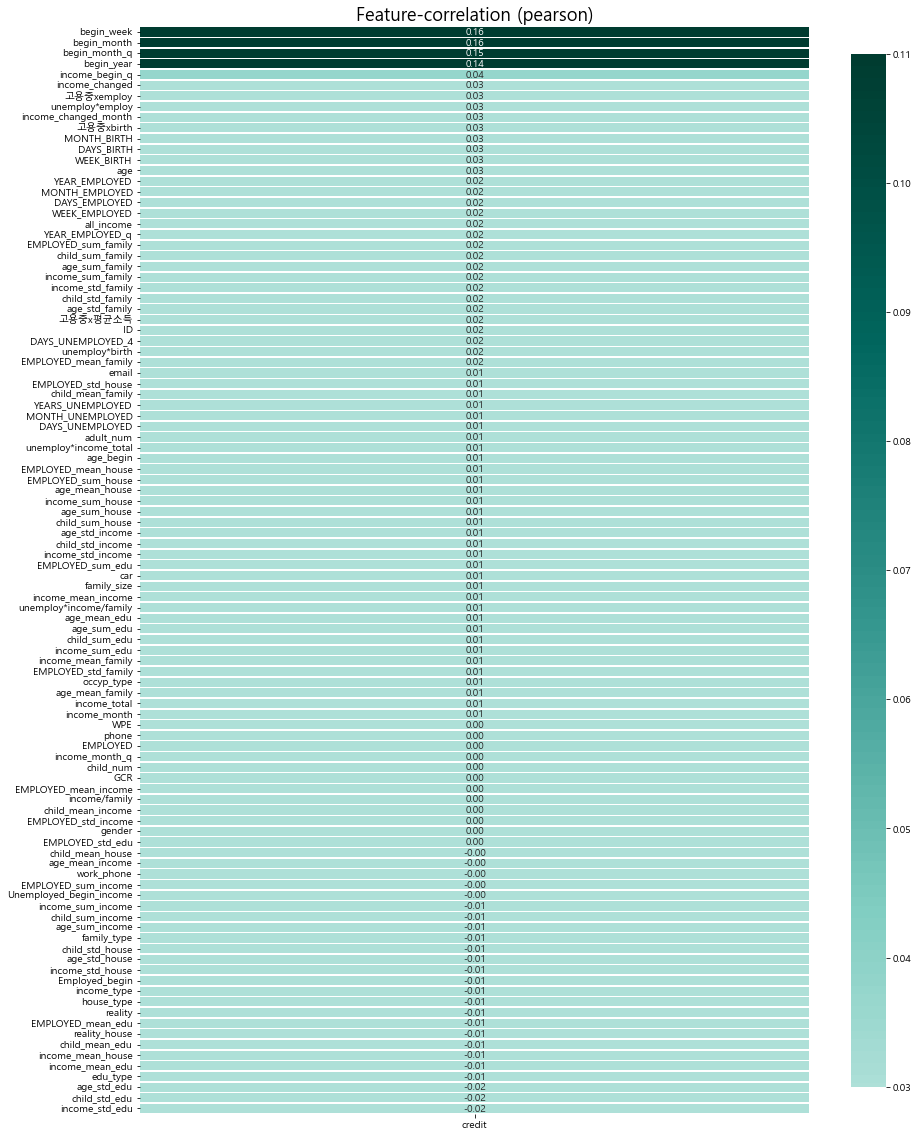

In [71]:
klib.corr_plot(data =train_X, 
               target =train_y,
               figsize = (15, 20))

plt.show()

#### - Feature Importance -

- XGBoost

In [72]:
selector = SelectFromModel(XGBClassifier(random_state=0), threshold=None)
fs = selector.fit(train_X, train_y).transform(train_X)

mask = selector.get_support()

fs_dict = {}
for i in range(len(train_X.columns)):
    fs_dict[train_X.columns[i]] = mask[i]

In [73]:
true_list = []
false_list = []
for i in fs_dict:
    if fs_dict[i] == True:
        true_list.append(i)
    else:
        false_list.append(i)

In [74]:
xgb = XGBClassifier(random_state=0)
xgb.fit(train_X, train_y)
feature_import = pd.Series(xgb.feature_importances_, train_X.columns)

In [75]:
# feature_importance 0인 feature들 리스트

import_zero = []
for i in feature_import.reset_index()[feature_import.reset_index()[0] == 0]['index']:
    import_zero.append(i)

In [76]:
# feature_importance 0인 값 제거

train_X = train_X.drop(columns = import_zero)
test = test.drop(columns = import_zero)

삭제 후 상관관계, 중요도 확인

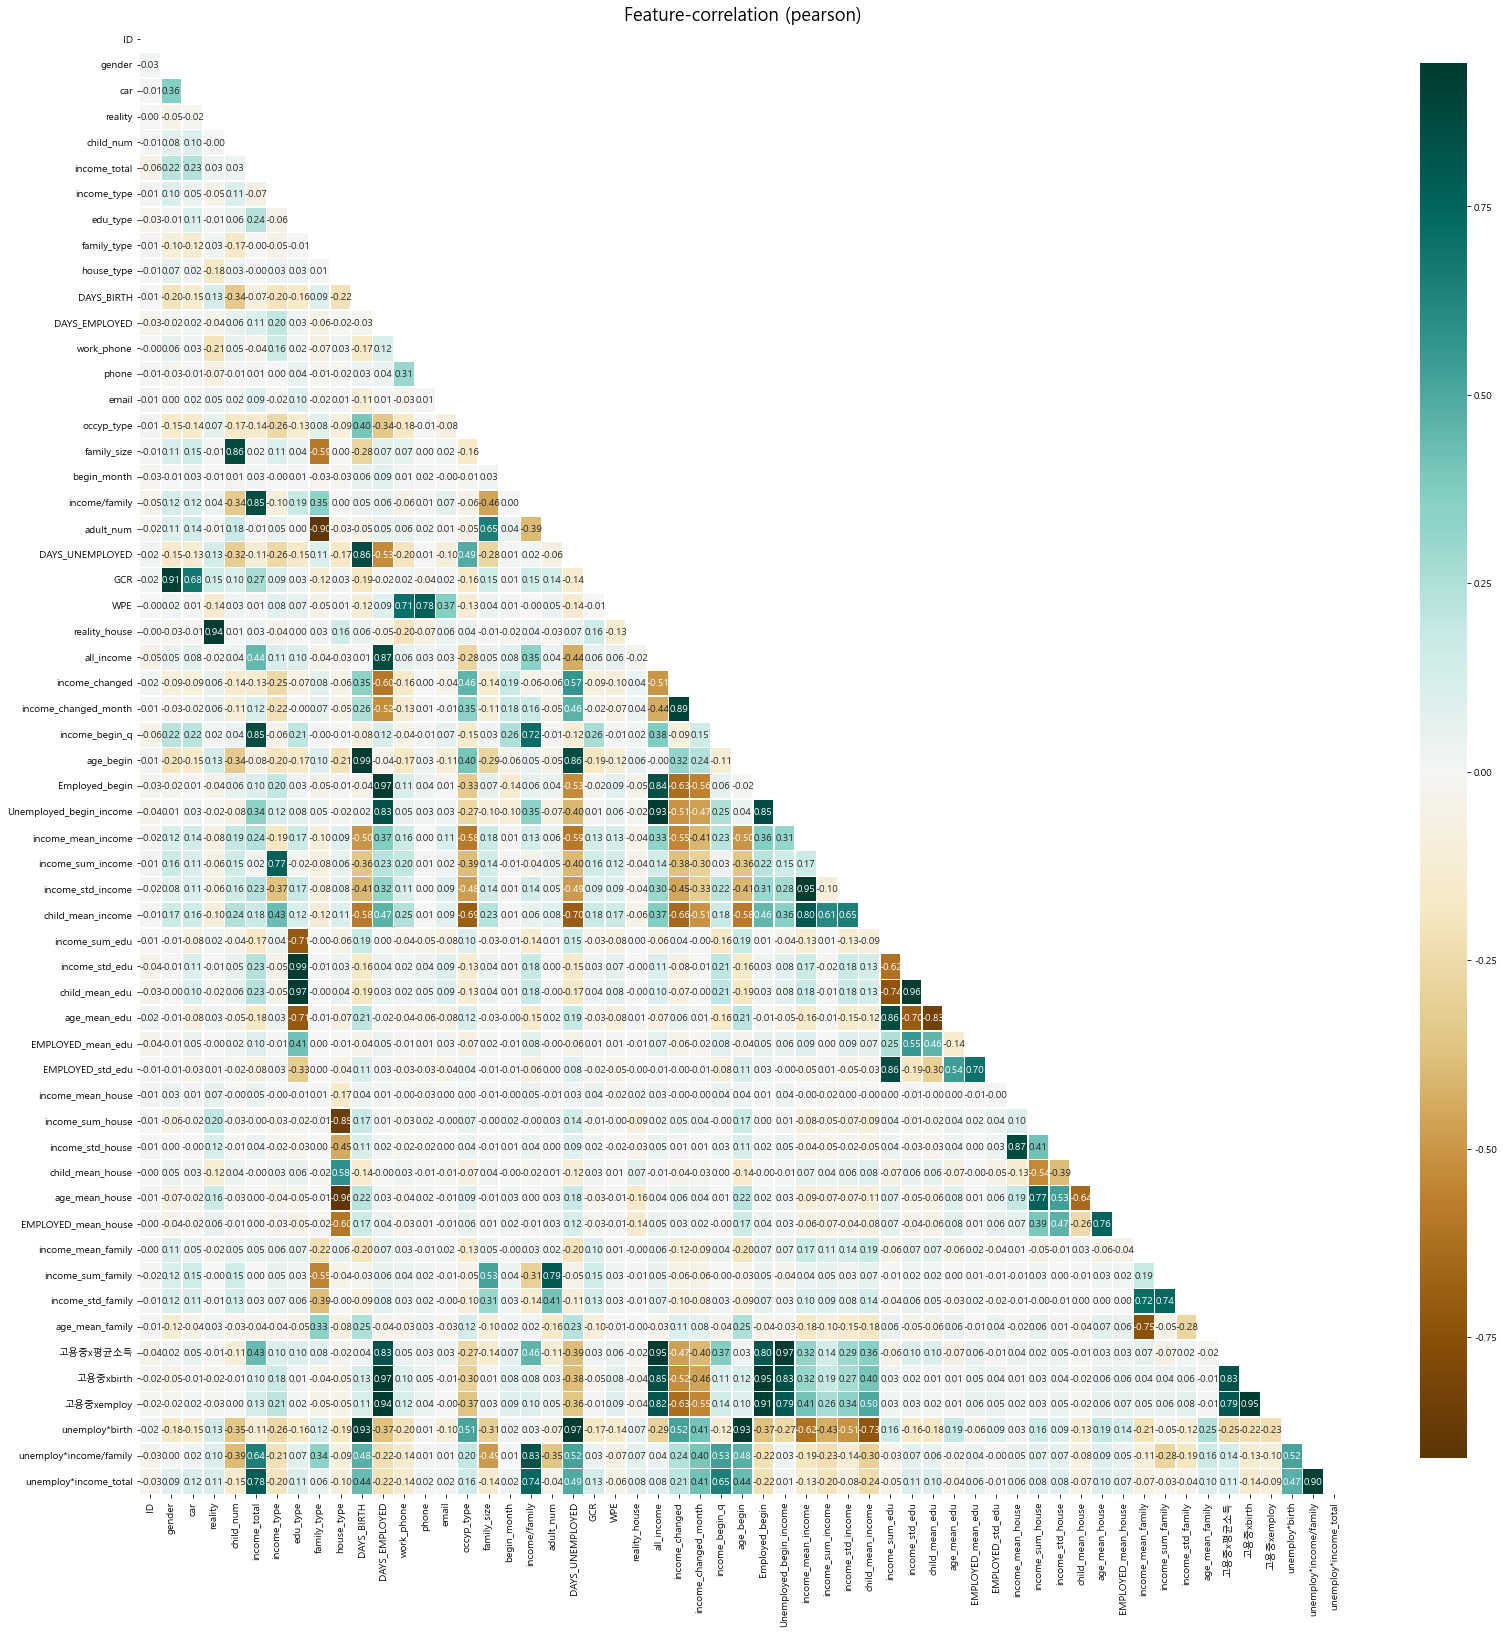

In [77]:
klib.corr_plot(data = train_X, figsize=(27, 27))
plt.show()

In [78]:
xgb = XGBClassifier(random_state=0)
xgb.fit(train_X, train_y)
feature_import = pd.Series(xgb.feature_importances_, train_X.columns)

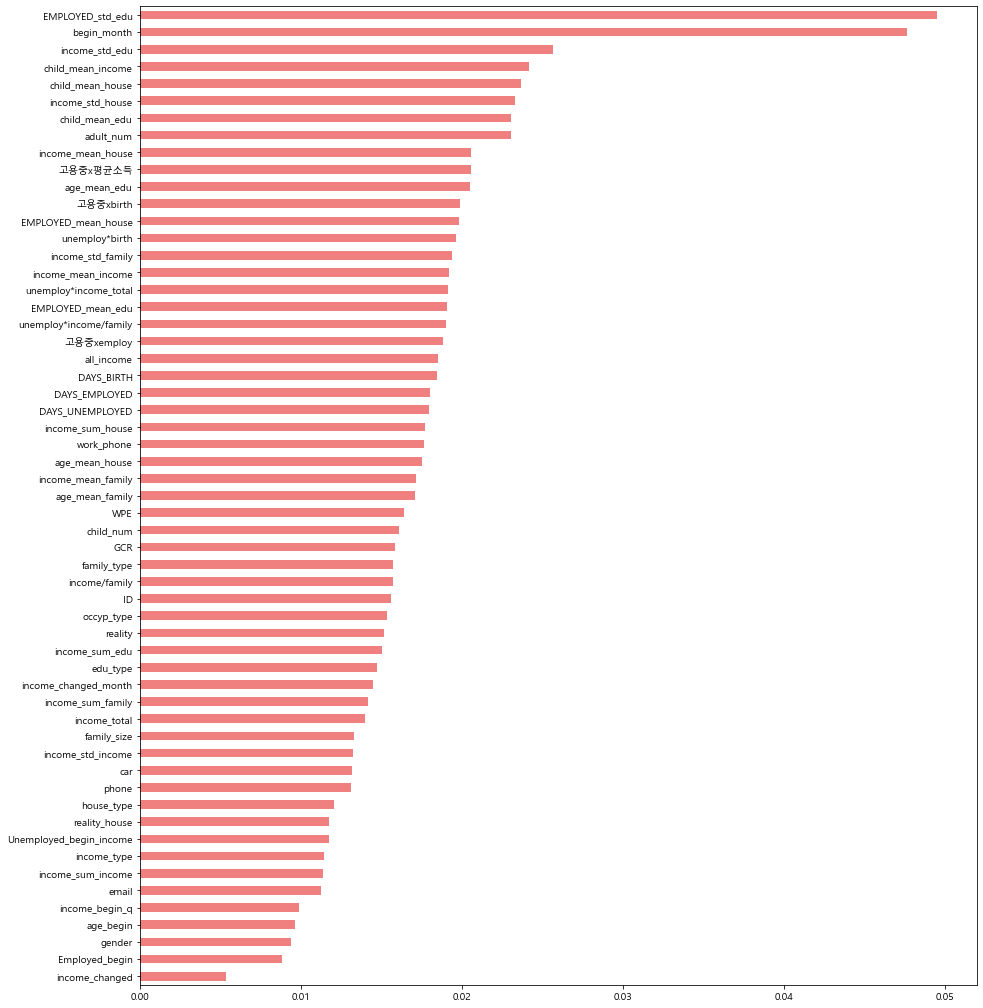

In [79]:
plt.figure(figsize=(15,18))
feature_import.sort_values(ascending = True).plot(kind = 'barh', color = 'lightcoral')
plt.show()

높은 상관관계(0.9 이상)를 보이는 feature 삭제

In [80]:
drop_col = ['gender', 'reality', 'age_begin', 'Employed_begin', 'Unemployed_begin_income', 'income_std_income', 'edu_type', 'house_type',
            'Unemployed_begin_income', 'DAYS_BIRTH']

for i in drop_col:
    if i in cat:
            cat.remove(i)    
            
train_X = train_X.drop(columns=drop_col)
test = test.drop(columns=drop_col)

## <font color = mediumblue> ** Modeling **

#### - 기본 모델 -

In [90]:
xgb_model = XGBClassifier(random_state=1234)

cv = StratifiedKFold(n_splits=20) 

cr_list = []
sub=np.zeros((test.shape[0], 3)) 

for train_index, test_index in cv.split(train_X, train_y) :
        x_train, x_test = train_X.iloc[list(train_index)], train_X.iloc[list(test_index)]
        y_train, y_test = train_y.iloc[list(train_index)], train_y.iloc[list(test_index)]
        model = xgb_model.fit(x_train,y_train)
        pred = model.predict_proba(x_test)
        cross_entropy = log_loss(y_test, pred)
        cr_list.append(cross_entropy)
        #sub +=model.predict_proba(test)
        
#mysubmission = sub/20

score = sum(cr_list)/20

In [91]:
print('(1234) cv=20 logloss:', score)

(1234) cv=20 logloss: 0.7182964616528895


#### - 하이퍼파라미터 튜닝 -

In [92]:
def objective(trial: Trial) -> float:

    params_xgb = {
        'objective': "multi:softmax",
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.2)
    
    model = XGBClassifier(**params_xgb)
    model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
             early_stopping_rounds=100,
             verbose=False,)
    
    pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, pred)
    
    return log_score

In [93]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'xgb_parameter_opt',
    direction='minimize',
    sampler = sampler,)

[I 2022-11-27 16:06:33,458] A new study created in memory with name: xgb_parameter_opt


In [94]:
study.optimize(objective, n_trials=300)

[I 2022-11-27 16:06:35,415] Trial 0 finished with value: 0.8940340955702987 and parameters: {'max_depth': 4, 'learning_rate': 0.7969454818643931, 'n_estimators': 380, 'min_child_weight': 6, 'gamma': 1.77071686435378e-07, 'subsample': 0.020511104188433976, 'colsample_bytree': 0.01306673923805328, 'reg_alpha': 0.08499808989182997, 'reg_lambda': 0.0006440507553993703}. Best is trial 0 with value: 0.8940340955702987.
[I 2022-11-27 16:06:44,374] Trial 1 finished with value: 0.8671849185286916 and parameters: {'max_depth': 7, 'learning_rate': 0.010994335574766204, 'n_estimators': 487, 'min_child_weight': 9, 'gamma': 4.997040685255803e-07, 'subsample': 0.02310201887845294, 'colsample_bytree': 0.023270677083837805, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995}. Best is trial 1 with value: 0.8671849185286916.
[I 2022-11-27 16:06:51,384] Trial 2 finished with value: 0.8183017364947388 and parameters: {'max_depth': 4, 'learning_rate': 0.038234752246751866, 'n_estimator

[I 2022-11-27 16:10:53,949] Trial 20 finished with value: 0.7395524013845935 and parameters: {'max_depth': 7, 'learning_rate': 0.02036020691042715, 'n_estimators': 437, 'min_child_weight': 7, 'gamma': 0.968881897552865, 'subsample': 0.5217105503048872, 'colsample_bytree': 0.5724222185288386, 'reg_alpha': 6.28501534513244e-06, 'reg_lambda': 0.00541692236322249}. Best is trial 11 with value: 0.7096031541224761.
[I 2022-11-27 16:11:23,093] Trial 21 finished with value: 0.7142606305716263 and parameters: {'max_depth': 9, 'learning_rate': 0.15233593151898836, 'n_estimators': 262, 'min_child_weight': 9, 'gamma': 0.02556947764614062, 'subsample': 0.919754909781373, 'colsample_bytree': 0.6178406636033833, 'reg_alpha': 0.0001912643975426691, 'reg_lambda': 0.012290981582101103}. Best is trial 11 with value: 0.7096031541224761.
[I 2022-11-27 16:11:53,203] Trial 22 finished with value: 0.7108611773727855 and parameters: {'max_depth': 8, 'learning_rate': 0.12338905140455683, 'n_estimators': 246, 'm

[I 2022-11-27 16:17:47,145] Trial 40 finished with value: 0.7071719289676709 and parameters: {'max_depth': 7, 'learning_rate': 0.1653547880081025, 'n_estimators': 499, 'min_child_weight': 7, 'gamma': 0.4352599933444461, 'subsample': 0.7588015301983678, 'colsample_bytree': 0.7684417203406622, 'reg_alpha': 0.01534833428430155, 'reg_lambda': 0.00012171366508037222}. Best is trial 40 with value: 0.7071719289676709.
[I 2022-11-27 16:18:14,643] Trial 41 finished with value: 0.7295420943470411 and parameters: {'max_depth': 7, 'learning_rate': 0.16769629732929892, 'n_estimators': 466, 'min_child_weight': 7, 'gamma': 0.5944930023061265, 'subsample': 0.743155262111787, 'colsample_bytree': 0.7704758488381737, 'reg_alpha': 0.008043459231115959, 'reg_lambda': 4.057520812428957e-05}. Best is trial 40 with value: 0.7071719289676709.
[I 2022-11-27 16:18:43,424] Trial 42 finished with value: 0.7346709088664516 and parameters: {'max_depth': 6, 'learning_rate': 0.27094188517295464, 'n_estimators': 493, '

[I 2022-11-27 16:27:13,984] Trial 60 finished with value: 0.7468213581706054 and parameters: {'max_depth': 8, 'learning_rate': 0.04788036601046967, 'n_estimators': 475, 'min_child_weight': 5, 'gamma': 0.6659034565156743, 'subsample': 0.26630249182626653, 'colsample_bytree': 0.06883617286635016, 'reg_alpha': 2.1731752551285727e-06, 'reg_lambda': 0.43422725637135545}. Best is trial 53 with value: 0.6922301798694621.
[I 2022-11-27 16:27:41,005] Trial 61 finished with value: 0.7169877068376843 and parameters: {'max_depth': 9, 'learning_rate': 0.09688771106076005, 'n_estimators': 500, 'min_child_weight': 4, 'gamma': 0.00773874847155734, 'subsample': 0.5218341017258561, 'colsample_bytree': 0.12582429437892817, 'reg_alpha': 1.1330939292291958e-06, 'reg_lambda': 0.08623469411199063}. Best is trial 53 with value: 0.6922301798694621.
[I 2022-11-27 16:28:08,205] Trial 62 finished with value: 0.6891757593925223 and parameters: {'max_depth': 9, 'learning_rate': 0.08603958077737618, 'n_estimators': 

[I 2022-11-27 16:50:26,217] Trial 80 finished with value: 0.7560453361614086 and parameters: {'max_depth': 9, 'learning_rate': 0.09118280537432352, 'n_estimators': 380, 'min_child_weight': 2, 'gamma': 0.000656368139990106, 'subsample': 0.37205025461597874, 'colsample_bytree': 0.041117264293614175, 'reg_alpha': 1.8207910670363157e-08, 'reg_lambda': 0.007718014611628425}. Best is trial 72 with value: 0.6888671052235285.
[I 2022-11-27 16:50:47,644] Trial 81 finished with value: 0.6955990337957477 and parameters: {'max_depth': 9, 'learning_rate': 0.06409783886796105, 'n_estimators': 338, 'min_child_weight': 2, 'gamma': 0.00637079609259785, 'subsample': 0.5672916409459672, 'colsample_bytree': 0.11456356794603427, 'reg_alpha': 4.1682896721292954e-08, 'reg_lambda': 0.024469318669337117}. Best is trial 72 with value: 0.6888671052235285.
[I 2022-11-27 16:51:07,092] Trial 82 finished with value: 0.7120558214776017 and parameters: {'max_depth': 9, 'learning_rate': 0.13131110547667904, 'n_estimato

[I 2022-11-27 16:58:23,781] Trial 99 finished with value: 0.6935178413618908 and parameters: {'max_depth': 8, 'learning_rate': 0.05672893116364496, 'n_estimators': 462, 'min_child_weight': 3, 'gamma': 0.00010391061765403629, 'subsample': 0.41328401631998085, 'colsample_bytree': 0.4330253558118465, 'reg_alpha': 3.3159646637566035e-07, 'reg_lambda': 0.02724372260752366}. Best is trial 95 with value: 0.6843344327053569.
[I 2022-11-27 16:58:44,928] Trial 100 finished with value: 0.727768779999611 and parameters: {'max_depth': 7, 'learning_rate': 0.05612914798184146, 'n_estimators': 462, 'min_child_weight': 4, 'gamma': 7.779008987949698e-05, 'subsample': 0.25567022763869857, 'colsample_bytree': 0.23156899329826092, 'reg_alpha': 1.7242166592500038e-06, 'reg_lambda': 0.07189479510470295}. Best is trial 95 with value: 0.6843344327053569.
[I 2022-11-27 16:59:19,594] Trial 101 finished with value: 0.7152601990673497 and parameters: {'max_depth': 8, 'learning_rate': 0.04366129232508497, 'n_estima

[I 2022-11-27 17:05:36,073] Trial 118 finished with value: 0.7205945259496536 and parameters: {'max_depth': 6, 'learning_rate': 0.10308249987586235, 'n_estimators': 477, 'min_child_weight': 3, 'gamma': 0.0001435226091781393, 'subsample': 0.8962267374880217, 'colsample_bytree': 0.10132840531271202, 'reg_alpha': 2.7178028181548936e-07, 'reg_lambda': 0.2218322734127235}. Best is trial 95 with value: 0.6843344327053569.
[I 2022-11-27 17:06:06,092] Trial 119 finished with value: 0.6953364988177936 and parameters: {'max_depth': 7, 'learning_rate': 0.08386010298859932, 'n_estimators': 463, 'min_child_weight': 4, 'gamma': 9.091196754121734e-05, 'subsample': 0.641240650576495, 'colsample_bytree': 0.17634947146908644, 'reg_alpha': 1.6479008152867803e-07, 'reg_lambda': 0.09509089573039681}. Best is trial 95 with value: 0.6843344327053569.
[I 2022-11-27 17:06:35,569] Trial 120 finished with value: 0.7172327313087501 and parameters: {'max_depth': 8, 'learning_rate': 0.11552240196968175, 'n_estimato

[I 2022-11-27 17:13:03,103] Trial 137 finished with value: 0.7157969761786607 and parameters: {'max_depth': 9, 'learning_rate': 0.06470058612414956, 'n_estimators': 438, 'min_child_weight': 2, 'gamma': 0.00017027449039887672, 'subsample': 0.39989452917573554, 'colsample_bytree': 0.12371014710785201, 'reg_alpha': 1.4326029606585892e-07, 'reg_lambda': 0.016463744128970868}. Best is trial 95 with value: 0.6843344327053569.
[I 2022-11-27 17:13:15,587] Trial 138 finished with value: 0.804510372281863 and parameters: {'max_depth': 1, 'learning_rate': 0.10824679233814508, 'n_estimators': 457, 'min_child_weight': 3, 'gamma': 0.00040232181757231397, 'subsample': 0.6085644180637438, 'colsample_bytree': 0.22364019718961411, 'reg_alpha': 1.0044169117594874e-08, 'reg_lambda': 0.26125564121280614}. Best is trial 95 with value: 0.6843344327053569.
[I 2022-11-27 17:13:53,936] Trial 139 finished with value: 0.715647740395161 and parameters: {'max_depth': 9, 'learning_rate': 0.09292072384527653, 'n_esti

[I 2022-11-27 17:20:12,877] Trial 156 finished with value: 0.7193151542690575 and parameters: {'max_depth': 9, 'learning_rate': 0.09238303521856978, 'n_estimators': 389, 'min_child_weight': 1, 'gamma': 7.858404727143111e-06, 'subsample': 0.5024808290735633, 'colsample_bytree': 0.30415838115546073, 'reg_alpha': 1.0180825789876774e-06, 'reg_lambda': 0.0002545536535756584}. Best is trial 153 with value: 0.6807871522846155.
[I 2022-11-27 17:20:41,905] Trial 157 finished with value: 0.7098570480632638 and parameters: {'max_depth': 9, 'learning_rate': 0.10096636133614308, 'n_estimators': 404, 'min_child_weight': 1, 'gamma': 1.680282378733625e-05, 'subsample': 0.7543352102782577, 'colsample_bytree': 0.49009132492393925, 'reg_alpha': 1.614943640410291e-07, 'reg_lambda': 0.30164401577630506}. Best is trial 153 with value: 0.6807871522846155.
[I 2022-11-27 17:21:10,640] Trial 158 finished with value: 0.7029086639289832 and parameters: {'max_depth': 9, 'learning_rate': 0.07716155921276334, 'n_est

[I 2022-11-27 17:27:50,390] Trial 175 finished with value: 0.7086559982174192 and parameters: {'max_depth': 9, 'learning_rate': 0.09608171762611019, 'n_estimators': 452, 'min_child_weight': 2, 'gamma': 3.751308642508494e-05, 'subsample': 0.5781040668054833, 'colsample_bytree': 0.06761811138291368, 'reg_alpha': 9.805624176722028e-08, 'reg_lambda': 0.9904346571282613}. Best is trial 153 with value: 0.6807871522846155.
[I 2022-11-27 17:28:12,942] Trial 176 finished with value: 0.7147414625005674 and parameters: {'max_depth': 9, 'learning_rate': 0.08466116912745367, 'n_estimators': 490, 'min_child_weight': 1, 'gamma': 0.00019093358486684965, 'subsample': 0.4795149100142153, 'colsample_bytree': 0.3585842798161528, 'reg_alpha': 8.038687585125145e-07, 'reg_lambda': 0.06619338304111243}. Best is trial 153 with value: 0.6807871522846155.
[I 2022-11-27 17:28:46,432] Trial 177 finished with value: 0.7130442589219766 and parameters: {'max_depth': 8, 'learning_rate': 0.05589297588037569, 'n_estimat

[I 2022-11-27 17:34:06,959] Trial 194 finished with value: 0.7115782904396437 and parameters: {'max_depth': 9, 'learning_rate': 0.08248819734606512, 'n_estimators': 361, 'min_child_weight': 2, 'gamma': 0.012051418649965784, 'subsample': 0.8229011785887507, 'colsample_bytree': 0.14364466336434437, 'reg_alpha': 1.009072843693421e-07, 'reg_lambda': 0.012746853758158283}. Best is trial 153 with value: 0.6807871522846155.
[I 2022-11-27 17:34:29,023] Trial 195 finished with value: 0.704219888158453 and parameters: {'max_depth': 9, 'learning_rate': 0.09803562332125317, 'n_estimators': 462, 'min_child_weight': 3, 'gamma': 0.02416943328778978, 'subsample': 0.7157947582031681, 'colsample_bytree': 0.08829847906845927, 'reg_alpha': 1.4525609106930024e-07, 'reg_lambda': 4.703713934293283e-06}. Best is trial 153 with value: 0.6807871522846155.
[I 2022-11-27 17:34:49,675] Trial 196 finished with value: 0.701811435615513 and parameters: {'max_depth': 9, 'learning_rate': 0.06567245742995802, 'n_estimat

[I 2022-11-27 17:42:06,071] Trial 213 finished with value: 0.6870845062350214 and parameters: {'max_depth': 9, 'learning_rate': 0.07328364578399889, 'n_estimators': 394, 'min_child_weight': 1, 'gamma': 0.0010491663101903081, 'subsample': 0.8317979914456498, 'colsample_bytree': 0.3065671087804688, 'reg_alpha': 4.0024769403362117e-07, 'reg_lambda': 0.29563941734413096}. Best is trial 153 with value: 0.6807871522846155.
[I 2022-11-27 17:42:39,414] Trial 214 finished with value: 0.7003507527835295 and parameters: {'max_depth': 9, 'learning_rate': 0.07255610698760342, 'n_estimators': 391, 'min_child_weight': 1, 'gamma': 0.001100957507609569, 'subsample': 0.8332567489676839, 'colsample_bytree': 0.2080435302396184, 'reg_alpha': 3.6156249140916996e-07, 'reg_lambda': 0.24999401278076008}. Best is trial 153 with value: 0.6807871522846155.
[I 2022-11-27 17:43:18,103] Trial 215 finished with value: 0.7014066022896445 and parameters: {'max_depth': 9, 'learning_rate': 0.06407513557386212, 'n_estimat

[I 2022-11-27 17:50:19,825] Trial 232 finished with value: 0.7194086683550477 and parameters: {'max_depth': 9, 'learning_rate': 0.0861785622391949, 'n_estimators': 362, 'min_child_weight': 1, 'gamma': 0.3240701955169002, 'subsample': 0.7539749669833786, 'colsample_bytree': 0.326816138626096, 'reg_alpha': 3.675202762251302e-07, 'reg_lambda': 0.06129769193834111}. Best is trial 218 with value: 0.6797127489677053.
[I 2022-11-27 17:50:44,272] Trial 233 finished with value: 0.695753707899624 and parameters: {'max_depth': 9, 'learning_rate': 0.09929904154248187, 'n_estimators': 354, 'min_child_weight': 1, 'gamma': 0.6732071193858089, 'subsample': 0.6533620277958204, 'colsample_bytree': 0.27082145873981933, 'reg_alpha': 2.1240217876128082e-07, 'reg_lambda': 0.10307967695618314}. Best is trial 218 with value: 0.6797127489677053.
[I 2022-11-27 17:50:53,174] Trial 234 finished with value: 0.7558315808267789 and parameters: {'max_depth': 9, 'learning_rate': 0.9931425937563386, 'n_estimators': 385

[I 2022-11-27 17:58:09,000] Trial 251 finished with value: 0.7086951038969788 and parameters: {'max_depth': 9, 'learning_rate': 0.057449415062569155, 'n_estimators': 477, 'min_child_weight': 1, 'gamma': 1.0243363014371793e-07, 'subsample': 0.9231653634894547, 'colsample_bytree': 0.257184037693052, 'reg_alpha': 2.4170238941561793e-07, 'reg_lambda': 0.07645441509443611}. Best is trial 218 with value: 0.6797127489677053.
[I 2022-11-27 17:58:39,045] Trial 252 finished with value: 0.6887477505853568 and parameters: {'max_depth': 9, 'learning_rate': 0.06998449236012155, 'n_estimators': 494, 'min_child_weight': 1, 'gamma': 4.7314728283894634e-07, 'subsample': 0.7904337607907584, 'colsample_bytree': 0.28715491760784917, 'reg_alpha': 9.582143891502495e-08, 'reg_lambda': 0.5601294737289149}. Best is trial 218 with value: 0.6797127489677053.
[I 2022-11-27 17:58:55,414] Trial 253 finished with value: 0.7464696790326811 and parameters: {'max_depth': 9, 'learning_rate': 0.06564249579421298, 'n_estim

[I 2022-11-27 18:08:07,325] Trial 270 finished with value: 0.7108583821306528 and parameters: {'max_depth': 9, 'learning_rate': 0.06777803130191176, 'n_estimators': 478, 'min_child_weight': 1, 'gamma': 6.285867380545262e-07, 'subsample': 0.6918924759623095, 'colsample_bytree': 0.35760006458274857, 'reg_alpha': 0.00035282160338874285, 'reg_lambda': 0.6468304465976004}. Best is trial 218 with value: 0.6797127489677053.
[I 2022-11-27 18:08:34,157] Trial 271 finished with value: 0.7155139649748655 and parameters: {'max_depth': 9, 'learning_rate': 0.07317770642895984, 'n_estimators': 468, 'min_child_weight': 1, 'gamma': 6.629413474764365e-07, 'subsample': 0.6282387707389712, 'colsample_bytree': 0.3005869938069425, 'reg_alpha': 0.0005759103214478629, 'reg_lambda': 0.39326618938235924}. Best is trial 218 with value: 0.6797127489677053.
[I 2022-11-27 18:09:02,651] Trial 272 finished with value: 0.7242740846445991 and parameters: {'max_depth': 4, 'learning_rate': 0.09770746084661842, 'n_estimat

[I 2022-11-27 18:18:50,595] Trial 289 finished with value: 0.6858334265554638 and parameters: {'max_depth': 9, 'learning_rate': 0.056686464618713135, 'n_estimators': 484, 'min_child_weight': 1, 'gamma': 0.00031781561934868973, 'subsample': 0.862593756192283, 'colsample_bytree': 0.26560603697872015, 'reg_alpha': 1.9516359303926224e-06, 'reg_lambda': 0.20414577454955327}. Best is trial 218 with value: 0.6797127489677053.
[I 2022-11-27 18:19:26,674] Trial 290 finished with value: 0.7082500846490535 and parameters: {'max_depth': 9, 'learning_rate': 0.05559295045069881, 'n_estimators': 483, 'min_child_weight': 1, 'gamma': 0.00031078654302595235, 'subsample': 0.8672396017977867, 'colsample_bytree': 0.2580082787325461, 'reg_alpha': 2.1967275712223748e-06, 'reg_lambda': 0.22155230942244727}. Best is trial 218 with value: 0.6797127489677053.
[I 2022-11-27 18:20:03,125] Trial 291 finished with value: 0.6983375590870429 and parameters: {'max_depth': 9, 'learning_rate': 0.06025741608617496, 'n_est

In [95]:
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

Best Score: 0.6797127489677053
Best trial: {'max_depth': 9, 'learning_rate': 0.07325260051836772, 'n_estimators': 366, 'min_child_weight': 1, 'gamma': 0.9626257925975001, 'subsample': 0.7541080762500043, 'colsample_bytree': 0.19915229279934754, 'reg_alpha': 2.59307957938509e-07, 'reg_lambda': 0.3011391109232776}


#### - 튜닝 후 최종 모델 -

In [100]:
best_params = study.best_trial.params

In [101]:
xgb_model = XGBClassifier(random_state=1234, **best_params)

cv = StratifiedKFold(n_splits=20, shuffle=True) 

cr_list = []
sub=np.zeros((test.shape[0], 3)) 

for train_index, test_index in cv.split(train_X, train_y) :
        x_train, x_test = train_X.iloc[list(train_index)], train_X.iloc[list(test_index)]
        y_train, y_test = train_y.iloc[list(train_index)], train_y.iloc[list(test_index)]
        model = xgb_model.fit(x_train,y_train)
        pred = model.predict_proba(x_test)
        cross_entropy = log_loss(y_test, pred)
        cr_list.append(cross_entropy)
        sub +=model.predict_proba(test)
        
mysubmission = sub/20

score = sum(cr_list)/20

In [102]:
print('cv=20 -> 튜닝 후 logloss:', score)

cv=20 -> 튜닝 후 logloss: 0.6862564980472353


#### - submission 파일 -

In [106]:
sample

,index,0,1,2
0,26457,0.046817,0.101921,0.851263
1,26458,0.233291,0.162523,0.604186
2,26459,0.032140,0.033957,0.933904
3,26460,0.089912,0.080379,0.829709
4,26461,0.094229,0.184294,0.721477
...,...,...,...,...
9995,36452,0.112039,0.207083,0.680878
9996,36453,0.236020,0.248431,0.515550
9997,36454,0.026199,0.078237,0.895564
9998,36455,0.126488,0.247933,0.625580


In [104]:
sample = pd.read_csv('./data/sample_submission.csv')
sample.loc[:,1:] = mysubmission

sample.to_csv(f'submission_XGBoost_20_300_{score:.4f}.csv', index=False)